# 54. 手法の組み合わせと総合評価

## 目的
- 実験51-53の結果を統合し、最適なフィルタリング戦略を決定
- ピボット + ポップカウントの組み合わせ効果を検証
- Firestoreでの実装設計を最終化

## 実験51-53の結果サマリー

| 手法 | 削減率 | Filter Recall | Recall@10 | 推奨度 |
|------|--------|---------------|-----------|--------|
| ピボットベース (t=20) | 46.9% | 99.1% | 90.5% | ◎ |
| ポップカウント (k=15) | 4.0% | 99.8% | 88.7% | △ |
| グレイコード (n=50k) | 87.5% | 45.5% | 44.6% | ✕ |

## 0. セットアップ

In [1]:
import numpy as np
import time
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src')
from itq_lsh import ITQLSH, hamming_distance_batch

DATA_DIR = Path("../data")
np.random.seed(42)

In [2]:
# データロード
print("Loading data...")
start_time = time.time()

embeddings = np.load(DATA_DIR / "wikipedia_400k_e5_base_embeddings.npy")
hashes_128 = np.load(DATA_DIR / "wikipedia_400k_e5_base_hashes_128bits.npy")
popcounts = np.load(DATA_DIR / "wikipedia_400k_popcounts_128bits.npy")
pivots = np.load(DATA_DIR / "pivots_8_furthest_first.npy")
pivot_distances = np.load(DATA_DIR / "wikipedia_400k_pivot_distances_8.npy")

print(f"Embeddings: {embeddings.shape}")
print(f"Hashes 128 bits: {hashes_128.shape}")
print(f"Popcounts: {popcounts.shape}")
print(f"Pivots: {pivots.shape}")
print(f"Pivot distances: {pivot_distances.shape}")
print(f"Load time: {time.time() - start_time:.1f}s")

Loading data...


Embeddings: (399029, 768)
Hashes 128 bits: (399029, 128)
Popcounts: (399029,)
Pivots: (8, 128)
Pivot distances: (399029, 8)
Load time: 0.6s


## 1. フィルタリング関数の定義

In [3]:
def hamming_distance(h1: np.ndarray, h2: np.ndarray) -> int:
    """2つのハッシュ間のハミング距離"""
    return np.sum(h1 != h2)

def popcount_filter(query_popcount: int, all_popcounts: np.ndarray, k: int) -> np.ndarray:
    """ポップカウントフィルタリング"""
    lower = query_popcount - k
    upper = query_popcount + k
    mask = (all_popcounts >= lower) & (all_popcounts <= upper)
    return np.where(mask)[0]

def pivot_filter(query_hash: np.ndarray, pivots: np.ndarray, 
                 all_pivot_distances: np.ndarray, threshold: int) -> np.ndarray:
    """ピボットフィルタリング"""
    n_docs, n_pivots = all_pivot_distances.shape
    query_pivot_dists = np.array([hamming_distance(query_hash, p) for p in pivots])
    
    mask = np.ones(n_docs, dtype=bool)
    for i in range(n_pivots):
        lower = query_pivot_dists[i] - threshold
        upper = query_pivot_dists[i] + threshold
        mask &= (all_pivot_distances[:, i] >= lower) & (all_pivot_distances[:, i] <= upper)
    
    return np.where(mask)[0]

def combined_filter(query_hash: np.ndarray, query_popcount: int,
                    pivots: np.ndarray, all_pivot_distances: np.ndarray,
                    all_popcounts: np.ndarray,
                    pivot_threshold: int, popcount_k: int) -> np.ndarray:
    """ピボット + ポップカウントの組み合わせフィルタリング"""
    # ポップカウントフィルタ
    pc_candidates = popcount_filter(query_popcount, all_popcounts, popcount_k)
    
    if len(pc_candidates) == 0:
        return np.array([], dtype=int)
    
    # ピボットフィルタ（ポップカウントで絞り込んだ候補に対して）
    n_pivots = pivots.shape[0]
    query_pivot_dists = np.array([hamming_distance(query_hash, p) for p in pivots])
    
    mask = np.ones(len(pc_candidates), dtype=bool)
    candidate_pivot_dists = all_pivot_distances[pc_candidates]
    
    for i in range(n_pivots):
        lower = query_pivot_dists[i] - pivot_threshold
        upper = query_pivot_dists[i] + pivot_threshold
        mask &= (candidate_pivot_dists[:, i] >= lower) & (candidate_pivot_dists[:, i] <= upper)
    
    return pc_candidates[mask]

## 2. 組み合わせフィルタリングの評価

In [4]:
def evaluate_combined_filter(
    embeddings: np.ndarray,
    hashes: np.ndarray,
    popcounts: np.ndarray,
    pivots: np.ndarray,
    pivot_distances: np.ndarray,
    configs: list,
    n_queries: int = 100,
    top_k: int = 10,
    candidate_limits: list = [100, 500, 1000, 2000]
):
    """
    組み合わせフィルタリングを評価
    
    configs: list of dict with keys 'pivot_threshold', 'popcount_k', 'name'
    """
    n_docs = len(embeddings)
    query_indices = np.random.choice(n_docs, n_queries, replace=False)
    
    # Ground truth計算
    print(f"Computing ground truth for {n_queries} queries...")
    ground_truth = []
    for q_idx in tqdm(query_indices, desc="Ground truth"):
        sims = embeddings @ embeddings[q_idx]
        sims[q_idx] = -1
        top_indices = np.argsort(sims)[-top_k:][::-1]
        ground_truth.append(set(top_indices))
    
    results = []
    
    for config in configs:
        name = config['name']
        pivot_t = config['pivot_threshold']
        pc_k = config['popcount_k']
        
        print(f"\nEvaluating {name}...")
        
        step1_candidates_list = []
        recalls = {limit: [] for limit in candidate_limits}
        filter_recall = []
        
        for i, q_idx in enumerate(tqdm(query_indices, desc=name)):
            query_hash = hashes[q_idx]
            query_pc = popcounts[q_idx]
            
            # 組み合わせフィルタ
            if pc_k is None:
                # ピボットのみ
                candidates = pivot_filter(query_hash, pivots, pivot_distances, pivot_t)
            elif pivot_t is None:
                # ポップカウントのみ
                candidates = popcount_filter(query_pc, popcounts, pc_k)
            else:
                # 組み合わせ
                candidates = combined_filter(
                    query_hash, query_pc, pivots, pivot_distances, popcounts, pivot_t, pc_k
                )
            
            candidates = candidates[candidates != q_idx]
            step1_candidates_list.append(len(candidates))
            
            # フィルタ後にTop-Kが含まれるか
            gt_in_candidates = len(ground_truth[i] & set(candidates)) / top_k
            filter_recall.append(gt_in_candidates)
            
            if len(candidates) == 0:
                for limit in candidate_limits:
                    recalls[limit].append(0.0)
                continue
            
            # ハミング距離でソート
            candidate_hashes = hashes[candidates]
            distances = hamming_distance_batch(query_hash, candidate_hashes)
            sorted_indices = np.argsort(distances)
            
            for limit in candidate_limits:
                if len(sorted_indices) < limit:
                    top_candidates = set(candidates[sorted_indices])
                else:
                    top_candidates = set(candidates[sorted_indices[:limit]])
                
                recall = len(top_candidates & ground_truth[i]) / top_k
                recalls[limit].append(recall)
        
        result = {
            'name': name,
            'pivot_threshold': pivot_t,
            'popcount_k': pc_k,
            'step1_candidates_mean': np.mean(step1_candidates_list),
            'reduction_rate': 1 - np.mean(step1_candidates_list) / n_docs,
            'filter_recall': np.mean(filter_recall),
        }
        
        for limit in candidate_limits:
            result[f'recall@{top_k}_limit{limit}'] = np.mean(recalls[limit])
        
        results.append(result)
        
        print(f"  Candidates: {result['step1_candidates_mean']:.0f} (reduction: {result['reduction_rate']:.1%})")
        print(f"  Filter Recall: {result['filter_recall']:.1%}")
        print(f"  Recall@10 (limit=1000): {result['recall@10_limit1000']:.1%}")
    
    return results

In [5]:
# 評価設定
configs = [
    # ピボットのみ
    {'name': 'Pivot t=20', 'pivot_threshold': 20, 'popcount_k': None},
    {'name': 'Pivot t=25', 'pivot_threshold': 25, 'popcount_k': None},
    {'name': 'Pivot t=30', 'pivot_threshold': 30, 'popcount_k': None},
    
    # ポップカウントのみ
    {'name': 'Popcount k=10', 'pivot_threshold': None, 'popcount_k': 10},
    {'name': 'Popcount k=15', 'pivot_threshold': None, 'popcount_k': 15},
    
    # 組み合わせ
    {'name': 'Pivot t=20 + PC k=15', 'pivot_threshold': 20, 'popcount_k': 15},
    {'name': 'Pivot t=25 + PC k=15', 'pivot_threshold': 25, 'popcount_k': 15},
    {'name': 'Pivot t=20 + PC k=10', 'pivot_threshold': 20, 'popcount_k': 10},
    {'name': 'Pivot t=25 + PC k=10', 'pivot_threshold': 25, 'popcount_k': 10},
]

results = evaluate_combined_filter(
    embeddings, hashes_128, popcounts, pivots, pivot_distances,
    configs=configs,
    n_queries=100,
    top_k=10
)

Computing ground truth for 100 queries...



Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]


Ground truth:   3%|▎         | 3/100 [00:00<00:04, 22.09it/s]


Ground truth:   6%|▌         | 6/100 [00:00<00:04, 22.58it/s]


Ground truth:   9%|▉         | 9/100 [00:00<00:03, 22.87it/s]


Ground truth:  12%|█▏        | 12/100 [00:00<00:03, 22.96it/s]


Ground truth:  15%|█▌        | 15/100 [00:00<00:03, 23.05it/s]


Ground truth:  18%|█▊        | 18/100 [00:00<00:03, 23.14it/s]


Ground truth:  21%|██        | 21/100 [00:00<00:03, 23.09it/s]


Ground truth:  24%|██▍       | 24/100 [00:01<00:03, 23.12it/s]


Ground truth:  27%|██▋       | 27/100 [00:01<00:03, 22.70it/s]


Ground truth:  30%|███       | 30/100 [00:01<00:03, 22.33it/s]


Ground truth:  33%|███▎      | 33/100 [00:01<00:03, 22.18it/s]


Ground truth:  36%|███▌      | 36/100 [00:01<00:02, 22.49it/s]


Ground truth:  39%|███▉      | 39/100 [00:01<00:02, 22.47it/s]


Ground truth:  42%|████▏     | 42/100 [00:01<00:02, 22.35it/s]


Ground truth:  45%|████▌     | 45/100 [00:01<00:02, 22.07it/s]


Ground truth:  48%|████▊     | 48/100 [00:02<00:02, 22.33it/s]


Ground truth:  51%|█████     | 51/100 [00:02<00:02, 22.40it/s]


Ground truth:  54%|█████▍    | 54/100 [00:02<00:02, 22.68it/s]


Ground truth:  57%|█████▋    | 57/100 [00:02<00:01, 22.82it/s]


Ground truth:  60%|██████    | 60/100 [00:02<00:01, 22.95it/s]


Ground truth:  63%|██████▎   | 63/100 [00:02<00:01, 23.06it/s]


Ground truth:  66%|██████▌   | 66/100 [00:02<00:01, 23.13it/s]


Ground truth:  69%|██████▉   | 69/100 [00:03<00:01, 23.15it/s]


Ground truth:  72%|███████▏  | 72/100 [00:03<00:01, 23.21it/s]


Ground truth:  75%|███████▌  | 75/100 [00:03<00:01, 23.20it/s]


Ground truth:  78%|███████▊  | 78/100 [00:03<00:00, 23.23it/s]


Ground truth:  81%|████████  | 81/100 [00:03<00:00, 22.78it/s]


Ground truth:  84%|████████▍ | 84/100 [00:03<00:00, 22.27it/s]


Ground truth:  87%|████████▋ | 87/100 [00:03<00:00, 21.87it/s]


Ground truth:  90%|█████████ | 90/100 [00:03<00:00, 22.14it/s]


Ground truth:  93%|█████████▎| 93/100 [00:04<00:00, 22.19it/s]


Ground truth:  96%|█████████▌| 96/100 [00:04<00:00, 22.18it/s]


Ground truth:  99%|█████████▉| 99/100 [00:04<00:00, 21.87it/s]


Ground truth: 100%|██████████| 100/100 [00:04<00:00, 22.58it/s]


Evaluating Pivot t=20...



Pivot t=20:   0%|          | 0/100 [00:00<?, ?it/s]


Pivot t=20:   2%|▏         | 2/100 [00:00<00:07, 13.55it/s]


Pivot t=20:   4%|▍         | 4/100 [00:00<00:07, 12.53it/s]


Pivot t=20:   6%|▌         | 6/100 [00:00<00:07, 13.16it/s]


Pivot t=20:   9%|▉         | 9/100 [00:00<00:05, 16.70it/s]


Pivot t=20:  13%|█▎        | 13/100 [00:00<00:03, 21.81it/s]


Pivot t=20:  16%|█▌        | 16/100 [00:00<00:04, 17.51it/s]


Pivot t=20:  18%|█▊        | 18/100 [00:01<00:04, 18.02it/s]


Pivot t=20:  21%|██        | 21/100 [00:01<00:04, 17.63it/s]


Pivot t=20:  24%|██▍       | 24/100 [00:01<00:04, 18.69it/s]


Pivot t=20:  27%|██▋       | 27/100 [00:01<00:03, 19.33it/s]


Pivot t=20:  30%|███       | 30/100 [00:01<00:03, 20.60it/s]


Pivot t=20:  33%|███▎      | 33/100 [00:01<00:03, 17.36it/s]


Pivot t=20:  38%|███▊      | 38/100 [00:02<00:02, 21.92it/s]


Pivot t=20:  41%|████      | 41/100 [00:02<00:02, 22.68it/s]


Pivot t=20:  44%|████▍     | 44/100 [00:02<00:02, 22.65it/s]


Pivot t=20:  47%|████▋     | 47/100 [00:02<00:02, 20.34it/s]


Pivot t=20:  50%|█████     | 50/100 [00:02<00:02, 18.34it/s]


Pivot t=20:  53%|█████▎    | 53/100 [00:02<00:02, 19.89it/s]


Pivot t=20:  56%|█████▌    | 56/100 [00:02<00:02, 17.55it/s]


Pivot t=20:  58%|█████▊    | 58/100 [00:03<00:02, 18.03it/s]


Pivot t=20:  60%|██████    | 60/100 [00:03<00:02, 18.30it/s]


Pivot t=20:  62%|██████▏   | 62/100 [00:03<00:02, 17.23it/s]


Pivot t=20:  64%|██████▍   | 64/100 [00:03<00:02, 17.80it/s]


Pivot t=20:  66%|██████▌   | 66/100 [00:03<00:01, 17.91it/s]


Pivot t=20:  69%|██████▉   | 69/100 [00:03<00:01, 20.17it/s]


Pivot t=20:  72%|███████▏  | 72/100 [00:03<00:01, 19.33it/s]


Pivot t=20:  75%|███████▌  | 75/100 [00:03<00:01, 19.99it/s]


Pivot t=20:  79%|███████▉  | 79/100 [00:04<00:00, 22.24it/s]


Pivot t=20:  82%|████████▏ | 82/100 [00:04<00:00, 23.68it/s]


Pivot t=20:  85%|████████▌ | 85/100 [00:04<00:00, 22.11it/s]


Pivot t=20:  88%|████████▊ | 88/100 [00:04<00:00, 22.68it/s]


Pivot t=20:  91%|█████████ | 91/100 [00:04<00:00, 22.10it/s]


Pivot t=20:  94%|█████████▍| 94/100 [00:04<00:00, 21.88it/s]


Pivot t=20:  97%|█████████▋| 97/100 [00:04<00:00, 21.00it/s]


Pivot t=20: 100%|██████████| 100/100 [00:05<00:00, 20.94it/s]


Pivot t=20: 100%|██████████| 100/100 [00:05<00:00, 19.63it/s]

  Candidates: 210609 (reduction: 47.2%)
  Filter Recall: 99.9%
  Recall@10 (limit=1000): 89.8%

Evaluating Pivot t=25...



Pivot t=25:   0%|          | 0/100 [00:00<?, ?it/s]


Pivot t=25:   2%|▏         | 2/100 [00:00<00:07, 13.45it/s]


Pivot t=25:   4%|▍         | 4/100 [00:00<00:08, 10.73it/s]


Pivot t=25:   6%|▌         | 6/100 [00:00<00:08, 10.83it/s]


Pivot t=25:   8%|▊         | 8/100 [00:00<00:07, 11.87it/s]


Pivot t=25:  10%|█         | 10/100 [00:00<00:08, 10.83it/s]


Pivot t=25:  13%|█▎        | 13/100 [00:01<00:05, 14.60it/s]


Pivot t=25:  15%|█▌        | 15/100 [00:01<00:06, 12.68it/s]


Pivot t=25:  17%|█▋        | 17/100 [00:01<00:07, 11.72it/s]


Pivot t=25:  20%|██        | 20/100 [00:01<00:05, 14.32it/s]


Pivot t=25:  22%|██▏       | 22/100 [00:01<00:05, 13.69it/s]


Pivot t=25:  24%|██▍       | 24/100 [00:01<00:05, 13.72it/s]


Pivot t=25:  26%|██▌       | 26/100 [00:02<00:06, 11.99it/s]


Pivot t=25:  28%|██▊       | 28/100 [00:02<00:05, 12.10it/s]


Pivot t=25:  30%|███       | 30/100 [00:02<00:05, 11.88it/s]


Pivot t=25:  32%|███▏      | 32/100 [00:02<00:06, 11.11it/s]


Pivot t=25:  34%|███▍      | 34/100 [00:02<00:06, 10.93it/s]


Pivot t=25:  38%|███▊      | 38/100 [00:02<00:04, 14.55it/s]


Pivot t=25:  40%|████      | 40/100 [00:03<00:04, 14.46it/s]


Pivot t=25:  43%|████▎     | 43/100 [00:03<00:03, 15.88it/s]


Pivot t=25:  45%|████▌     | 45/100 [00:03<00:03, 14.00it/s]


Pivot t=25:  47%|████▋     | 47/100 [00:03<00:04, 12.65it/s]


Pivot t=25:  49%|████▉     | 49/100 [00:03<00:03, 12.89it/s]


Pivot t=25:  51%|█████     | 51/100 [00:04<00:03, 12.35it/s]


Pivot t=25:  54%|█████▍    | 54/100 [00:04<00:03, 14.38it/s]


Pivot t=25:  56%|█████▌    | 56/100 [00:04<00:03, 13.75it/s]


Pivot t=25:  58%|█████▊    | 58/100 [00:04<00:03, 13.67it/s]


Pivot t=25:  60%|██████    | 60/100 [00:04<00:03, 12.41it/s]


Pivot t=25:  62%|██████▏   | 62/100 [00:04<00:03, 11.73it/s]


Pivot t=25:  64%|██████▍   | 64/100 [00:05<00:03, 11.61it/s]


Pivot t=25:  66%|██████▌   | 66/100 [00:05<00:02, 11.35it/s]


Pivot t=25:  69%|██████▉   | 69/100 [00:05<00:02, 12.95it/s]


Pivot t=25:  71%|███████   | 71/100 [00:05<00:02, 12.23it/s]


Pivot t=25:  73%|███████▎  | 73/100 [00:05<00:02, 12.36it/s]


Pivot t=25:  75%|███████▌  | 75/100 [00:05<00:02, 12.11it/s]


Pivot t=25:  78%|███████▊  | 78/100 [00:06<00:01, 13.63it/s]


Pivot t=25:  80%|████████  | 80/100 [00:06<00:01, 14.59it/s]


Pivot t=25:  82%|████████▏ | 82/100 [00:06<00:01, 13.80it/s]


Pivot t=25:  84%|████████▍ | 84/100 [00:06<00:01, 12.77it/s]


Pivot t=25:  86%|████████▌ | 86/100 [00:06<00:01, 13.26it/s]


Pivot t=25:  88%|████████▊ | 88/100 [00:06<00:00, 12.68it/s]


Pivot t=25:  90%|█████████ | 90/100 [00:07<00:00, 11.75it/s]


Pivot t=25:  92%|█████████▏| 92/100 [00:07<00:00, 11.41it/s]


Pivot t=25:  94%|█████████▍| 94/100 [00:07<00:00, 12.78it/s]


Pivot t=25:  96%|█████████▌| 96/100 [00:07<00:00, 12.72it/s]


Pivot t=25:  98%|█████████▊| 98/100 [00:07<00:00, 13.04it/s]


Pivot t=25: 100%|██████████| 100/100 [00:07<00:00, 11.90it/s]


Pivot t=25: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]

  Candidates: 289235 (reduction: 27.5%)
  Filter Recall: 99.9%
  Recall@10 (limit=1000): 89.9%

Evaluating Pivot t=30...



Pivot t=30:   0%|          | 0/100 [00:00<?, ?it/s]


Pivot t=30:   2%|▏         | 2/100 [00:00<00:09, 10.44it/s]


Pivot t=30:   4%|▍         | 4/100 [00:00<00:09,  9.82it/s]


Pivot t=30:   5%|▌         | 5/100 [00:00<00:09,  9.79it/s]


Pivot t=30:   6%|▌         | 6/100 [00:00<00:09,  9.84it/s]


Pivot t=30:   8%|▊         | 8/100 [00:00<00:09, 10.05it/s]


Pivot t=30:  10%|█         | 10/100 [00:01<00:09,  9.76it/s]


Pivot t=30:  13%|█▎        | 13/100 [00:01<00:07, 12.10it/s]


Pivot t=30:  15%|█▌        | 15/100 [00:01<00:07, 11.27it/s]


Pivot t=30:  17%|█▋        | 17/100 [00:01<00:07, 10.65it/s]


Pivot t=30:  20%|██        | 20/100 [00:01<00:06, 12.94it/s]


Pivot t=30:  22%|██▏       | 22/100 [00:01<00:06, 12.00it/s]


Pivot t=30:  24%|██▍       | 24/100 [00:02<00:06, 11.47it/s]


Pivot t=30:  26%|██▌       | 26/100 [00:02<00:06, 10.94it/s]


Pivot t=30:  28%|██▊       | 28/100 [00:02<00:06, 10.68it/s]


Pivot t=30:  30%|███       | 30/100 [00:02<00:06, 10.49it/s]


Pivot t=30:  32%|███▏      | 32/100 [00:02<00:06, 10.30it/s]


Pivot t=30:  34%|███▍      | 34/100 [00:03<00:06, 10.07it/s]


Pivot t=30:  37%|███▋      | 37/100 [00:03<00:05, 12.33it/s]


Pivot t=30:  39%|███▉      | 39/100 [00:03<00:05, 11.86it/s]


Pivot t=30:  41%|████      | 41/100 [00:03<00:05, 10.96it/s]


Pivot t=30:  43%|████▎     | 43/100 [00:03<00:04, 12.01it/s]


Pivot t=30:  45%|████▌     | 45/100 [00:04<00:04, 11.69it/s]


Pivot t=30:  47%|████▋     | 47/100 [00:04<00:04, 11.42it/s]


Pivot t=30:  49%|████▉     | 49/100 [00:04<00:04, 10.81it/s]


Pivot t=30:  51%|█████     | 51/100 [00:04<00:04, 10.46it/s]


Pivot t=30:  53%|█████▎    | 53/100 [00:04<00:03, 11.83it/s]


Pivot t=30:  55%|█████▌    | 55/100 [00:04<00:04, 11.18it/s]


Pivot t=30:  57%|█████▋    | 57/100 [00:05<00:03, 10.89it/s]


Pivot t=30:  59%|█████▉    | 59/100 [00:05<00:03, 10.48it/s]


Pivot t=30:  61%|██████    | 61/100 [00:05<00:03, 10.34it/s]


Pivot t=30:  63%|██████▎   | 63/100 [00:05<00:03, 10.30it/s]


Pivot t=30:  65%|██████▌   | 65/100 [00:05<00:03, 10.13it/s]


Pivot t=30:  67%|██████▋   | 67/100 [00:06<00:02, 11.14it/s]


Pivot t=30:  69%|██████▉   | 69/100 [00:06<00:02, 10.99it/s]


Pivot t=30:  71%|███████   | 71/100 [00:06<00:02, 10.23it/s]


Pivot t=30:  73%|███████▎  | 73/100 [00:06<00:02, 10.19it/s]


Pivot t=30:  75%|███████▌  | 75/100 [00:06<00:02, 10.15it/s]


Pivot t=30:  77%|███████▋  | 77/100 [00:07<00:01, 11.68it/s]


Pivot t=30:  79%|███████▉  | 79/100 [00:07<00:01, 11.10it/s]


Pivot t=30:  81%|████████  | 81/100 [00:07<00:01, 12.14it/s]


Pivot t=30:  83%|████████▎ | 83/100 [00:07<00:01, 11.36it/s]


Pivot t=30:  85%|████████▌ | 85/100 [00:07<00:01, 11.33it/s]


Pivot t=30:  87%|████████▋ | 87/100 [00:07<00:01, 11.37it/s]


Pivot t=30:  89%|████████▉ | 89/100 [00:08<00:01, 10.52it/s]


Pivot t=30:  91%|█████████ | 91/100 [00:08<00:00, 10.33it/s]


Pivot t=30:  93%|█████████▎| 93/100 [00:08<00:00, 10.95it/s]


Pivot t=30:  95%|█████████▌| 95/100 [00:08<00:00, 10.85it/s]


Pivot t=30:  97%|█████████▋| 97/100 [00:08<00:00, 10.29it/s]


Pivot t=30:  99%|█████████▉| 99/100 [00:09<00:00, 10.23it/s]


Pivot t=30: 100%|██████████| 100/100 [00:09<00:00, 10.87it/s]

  Candidates: 335749 (reduction: 15.9%)
  Filter Recall: 100.0%
  Recall@10 (limit=1000): 89.9%

Evaluating Popcount k=10...



Popcount k=10:   0%|          | 0/100 [00:00<?, ?it/s]


Popcount k=10:   2%|▏         | 2/100 [00:00<00:08, 11.44it/s]


Popcount k=10:   4%|▍         | 4/100 [00:00<00:08, 11.14it/s]


Popcount k=10:   6%|▌         | 6/100 [00:00<00:08, 10.68it/s]


Popcount k=10:   8%|▊         | 8/100 [00:00<00:08, 10.75it/s]


Popcount k=10:  10%|█         | 10/100 [00:00<00:08, 10.50it/s]


Popcount k=10:  12%|█▏        | 12/100 [00:01<00:07, 12.04it/s]


Popcount k=10:  14%|█▍        | 14/100 [00:01<00:06, 12.64it/s]


Popcount k=10:  16%|█▌        | 16/100 [00:01<00:07, 11.43it/s]


Popcount k=10:  18%|█▊        | 18/100 [00:01<00:06, 12.45it/s]


Popcount k=10:  20%|██        | 20/100 [00:01<00:06, 11.72it/s]


Popcount k=10:  23%|██▎       | 23/100 [00:01<00:05, 13.09it/s]


Popcount k=10:  25%|██▌       | 25/100 [00:02<00:06, 12.10it/s]


Popcount k=10:  27%|██▋       | 27/100 [00:02<00:06, 11.46it/s]


Popcount k=10:  29%|██▉       | 29/100 [00:02<00:06, 11.55it/s]


Popcount k=10:  31%|███       | 31/100 [00:02<00:05, 12.48it/s]


Popcount k=10:  33%|███▎      | 33/100 [00:02<00:05, 11.72it/s]


Popcount k=10:  35%|███▌      | 35/100 [00:03<00:05, 11.33it/s]


Popcount k=10:  37%|███▋      | 37/100 [00:03<00:05, 12.55it/s]


Popcount k=10:  39%|███▉      | 39/100 [00:03<00:04, 13.24it/s]


Popcount k=10:  42%|████▏     | 42/100 [00:03<00:04, 14.48it/s]


Popcount k=10:  44%|████▍     | 44/100 [00:03<00:04, 13.22it/s]


Popcount k=10:  46%|████▌     | 46/100 [00:03<00:04, 13.05it/s]


Popcount k=10:  48%|████▊     | 48/100 [00:03<00:04, 12.03it/s]


Popcount k=10:  50%|█████     | 50/100 [00:04<00:04, 11.31it/s]


Popcount k=10:  52%|█████▏    | 52/100 [00:04<00:04, 10.78it/s]


Popcount k=10:  54%|█████▍    | 54/100 [00:04<00:03, 11.65it/s]


Popcount k=10:  56%|█████▌    | 56/100 [00:04<00:03, 11.68it/s]


Popcount k=10:  58%|█████▊    | 58/100 [00:04<00:03, 12.08it/s]


Popcount k=10:  60%|██████    | 60/100 [00:04<00:03, 12.43it/s]


Popcount k=10:  62%|██████▏   | 62/100 [00:05<00:02, 12.75it/s]


Popcount k=10:  64%|██████▍   | 64/100 [00:05<00:02, 12.86it/s]


Popcount k=10:  66%|██████▌   | 66/100 [00:05<00:03, 11.30it/s]


Popcount k=10:  68%|██████▊   | 68/100 [00:05<00:02, 12.42it/s]


Popcount k=10:  70%|███████   | 70/100 [00:05<00:02, 12.28it/s]


Popcount k=10:  72%|███████▏  | 72/100 [00:05<00:02, 12.28it/s]


Popcount k=10:  74%|███████▍  | 74/100 [00:06<00:02, 12.80it/s]


Popcount k=10:  76%|███████▌  | 76/100 [00:06<00:01, 12.20it/s]


Popcount k=10:  78%|███████▊  | 78/100 [00:06<00:01, 12.99it/s]


Popcount k=10:  80%|████████  | 80/100 [00:06<00:01, 11.80it/s]


Popcount k=10:  82%|████████▏ | 82/100 [00:06<00:01, 12.27it/s]


Popcount k=10:  84%|████████▍ | 84/100 [00:06<00:01, 11.82it/s]


Popcount k=10:  86%|████████▌ | 86/100 [00:07<00:01, 11.21it/s]


Popcount k=10:  88%|████████▊ | 88/100 [00:07<00:00, 12.37it/s]


Popcount k=10:  90%|█████████ | 90/100 [00:07<00:00, 12.10it/s]


Popcount k=10:  92%|█████████▏| 92/100 [00:07<00:00, 11.20it/s]


Popcount k=10:  94%|█████████▍| 94/100 [00:07<00:00, 10.79it/s]


Popcount k=10:  96%|█████████▌| 96/100 [00:08<00:00, 10.59it/s]


Popcount k=10:  98%|█████████▊| 98/100 [00:08<00:00, 10.43it/s]


Popcount k=10: 100%|██████████| 100/100 [00:08<00:00, 10.41it/s]


Popcount k=10: 100%|██████████| 100/100 [00:08<00:00, 11.82it/s]

  Candidates: 323235 (reduction: 19.0%)
  Filter Recall: 91.8%
  Recall@10 (limit=1000): 83.6%

Evaluating Popcount k=15...



Popcount k=15:   0%|          | 0/100 [00:00<?, ?it/s]


Popcount k=15:   1%|          | 1/100 [00:00<00:09,  9.98it/s]


Popcount k=15:   2%|▏         | 2/100 [00:00<00:10,  9.54it/s]


Popcount k=15:   3%|▎         | 3/100 [00:00<00:10,  9.59it/s]


Popcount k=15:   4%|▍         | 4/100 [00:00<00:10,  9.55it/s]


Popcount k=15:   5%|▌         | 5/100 [00:00<00:10,  9.45it/s]


Popcount k=15:   6%|▌         | 6/100 [00:00<00:09,  9.40it/s]


Popcount k=15:   7%|▋         | 7/100 [00:00<00:09,  9.45it/s]


Popcount k=15:   8%|▊         | 8/100 [00:00<00:09,  9.43it/s]


Popcount k=15:   9%|▉         | 9/100 [00:00<00:09,  9.40it/s]


Popcount k=15:  10%|█         | 10/100 [00:01<00:09,  9.37it/s]


Popcount k=15:  12%|█▏        | 12/100 [00:01<00:08,  9.85it/s]


Popcount k=15:  13%|█▎        | 13/100 [00:01<00:08,  9.70it/s]


Popcount k=15:  15%|█▌        | 15/100 [00:01<00:08,  9.70it/s]


Popcount k=15:  16%|█▌        | 16/100 [00:01<00:08,  9.64it/s]


Popcount k=15:  18%|█▊        | 18/100 [00:01<00:08, 10.17it/s]


Popcount k=15:  20%|██        | 20/100 [00:02<00:08,  9.90it/s]


Popcount k=15:  22%|██▏       | 22/100 [00:02<00:07, 10.21it/s]


Popcount k=15:  24%|██▍       | 24/100 [00:02<00:07,  9.89it/s]


Popcount k=15:  25%|██▌       | 25/100 [00:02<00:07,  9.83it/s]


Popcount k=15:  26%|██▌       | 26/100 [00:02<00:07,  9.72it/s]


Popcount k=15:  27%|██▋       | 27/100 [00:02<00:07,  9.59it/s]


Popcount k=15:  28%|██▊       | 28/100 [00:02<00:07,  9.54it/s]


Popcount k=15:  30%|███       | 30/100 [00:03<00:06, 10.60it/s]


Popcount k=15:  32%|███▏      | 32/100 [00:03<00:06, 10.26it/s]


Popcount k=15:  34%|███▍      | 34/100 [00:03<00:06,  9.58it/s]


Popcount k=15:  35%|███▌      | 35/100 [00:03<00:06,  9.56it/s]


Popcount k=15:  37%|███▋      | 37/100 [00:03<00:06, 10.03it/s]


Popcount k=15:  39%|███▉      | 39/100 [00:03<00:06, 10.16it/s]


Popcount k=15:  41%|████      | 41/100 [00:04<00:05, 10.52it/s]


Popcount k=15:  43%|████▎     | 43/100 [00:04<00:05, 10.31it/s]


Popcount k=15:  45%|████▌     | 45/100 [00:04<00:05,  9.95it/s]


Popcount k=15:  46%|████▌     | 46/100 [00:04<00:05,  9.93it/s]


Popcount k=15:  47%|████▋     | 47/100 [00:04<00:05,  9.79it/s]


Popcount k=15:  48%|████▊     | 48/100 [00:04<00:05,  9.64it/s]


Popcount k=15:  49%|████▉     | 49/100 [00:04<00:05,  9.43it/s]


Popcount k=15:  50%|█████     | 50/100 [00:05<00:05,  9.38it/s]


Popcount k=15:  51%|█████     | 51/100 [00:05<00:05,  9.34it/s]


Popcount k=15:  52%|█████▏    | 52/100 [00:05<00:05,  9.32it/s]


Popcount k=15:  53%|█████▎    | 53/100 [00:05<00:05,  9.31it/s]


Popcount k=15:  55%|█████▌    | 55/100 [00:05<00:04,  9.85it/s]


Popcount k=15:  56%|█████▌    | 56/100 [00:05<00:04,  9.79it/s]


Popcount k=15:  57%|█████▋    | 57/100 [00:05<00:04,  9.71it/s]


Popcount k=15:  58%|█████▊    | 58/100 [00:05<00:04,  9.66it/s]


Popcount k=15:  60%|██████    | 60/100 [00:06<00:04,  9.75it/s]


Popcount k=15:  61%|██████    | 61/100 [00:06<00:04,  9.63it/s]


Popcount k=15:  63%|██████▎   | 63/100 [00:06<00:03, 10.01it/s]


Popcount k=15:  64%|██████▍   | 64/100 [00:06<00:03,  9.93it/s]


Popcount k=15:  65%|██████▌   | 65/100 [00:06<00:03,  9.82it/s]


Popcount k=15:  66%|██████▌   | 66/100 [00:06<00:03,  9.68it/s]


Popcount k=15:  68%|██████▊   | 68/100 [00:06<00:03,  9.86it/s]


Popcount k=15:  69%|██████▉   | 69/100 [00:07<00:03,  9.65it/s]


Popcount k=15:  71%|███████   | 71/100 [00:07<00:02,  9.67it/s]


Popcount k=15:  73%|███████▎  | 73/100 [00:07<00:02,  9.81it/s]


Popcount k=15:  75%|███████▌  | 75/100 [00:07<00:02,  9.90it/s]


Popcount k=15:  76%|███████▌  | 76/100 [00:07<00:02,  9.80it/s]


Popcount k=15:  78%|███████▊  | 78/100 [00:07<00:02, 10.10it/s]


Popcount k=15:  80%|████████  | 80/100 [00:08<00:02,  9.84it/s]


Popcount k=15:  81%|████████  | 81/100 [00:08<00:01,  9.71it/s]


Popcount k=15:  82%|████████▏ | 82/100 [00:08<00:01,  9.70it/s]


Popcount k=15:  83%|████████▎ | 83/100 [00:08<00:01,  9.59it/s]


Popcount k=15:  84%|████████▍ | 84/100 [00:08<00:01,  9.49it/s]


Popcount k=15:  85%|████████▌ | 85/100 [00:08<00:01,  9.49it/s]


Popcount k=15:  86%|████████▌ | 86/100 [00:08<00:01,  9.43it/s]


Popcount k=15:  88%|████████▊ | 88/100 [00:09<00:01,  9.72it/s]


Popcount k=15:  89%|████████▉ | 89/100 [00:09<00:01,  9.64it/s]


Popcount k=15:  90%|█████████ | 90/100 [00:09<00:01,  9.66it/s]


Popcount k=15:  91%|█████████ | 91/100 [00:09<00:00,  9.57it/s]


Popcount k=15:  92%|█████████▏| 92/100 [00:09<00:00,  9.49it/s]


Popcount k=15:  93%|█████████▎| 93/100 [00:09<00:00,  9.43it/s]


Popcount k=15:  94%|█████████▍| 94/100 [00:09<00:00,  9.46it/s]


Popcount k=15:  95%|█████████▌| 95/100 [00:09<00:00,  9.47it/s]


Popcount k=15:  96%|█████████▌| 96/100 [00:09<00:00,  9.45it/s]


Popcount k=15:  97%|█████████▋| 97/100 [00:09<00:00,  9.43it/s]


Popcount k=15:  98%|█████████▊| 98/100 [00:10<00:00,  9.42it/s]


Popcount k=15:  99%|█████████▉| 99/100 [00:10<00:00,  9.41it/s]


Popcount k=15: 100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


Popcount k=15: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]

  Candidates: 378527 (reduction: 5.1%)
  Filter Recall: 99.4%
  Recall@10 (limit=1000): 89.0%

Evaluating Pivot t=20 + PC k=15...



Pivot t=20 + PC k=15:   0%|          | 0/100 [00:00<?, ?it/s]


Pivot t=20 + PC k=15:   2%|▏         | 2/100 [00:00<00:04, 19.76it/s]


Pivot t=20 + PC k=15:   4%|▍         | 4/100 [00:00<00:06, 15.00it/s]


Pivot t=20 + PC k=15:   6%|▌         | 6/100 [00:00<00:05, 16.11it/s]


Pivot t=20 + PC k=15:   9%|▉         | 9/100 [00:00<00:04, 19.06it/s]


Pivot t=20 + PC k=15:  11%|█         | 11/100 [00:00<00:04, 19.34it/s]


Pivot t=20 + PC k=15:  14%|█▍        | 14/100 [00:00<00:04, 21.49it/s]


Pivot t=20 + PC k=15:  17%|█▋        | 17/100 [00:00<00:04, 18.58it/s]


Pivot t=20 + PC k=15:  20%|██        | 20/100 [00:01<00:03, 21.32it/s]


Pivot t=20 + PC k=15:  23%|██▎       | 23/100 [00:01<00:03, 21.83it/s]


Pivot t=20 + PC k=15:  26%|██▌       | 26/100 [00:01<00:03, 21.08it/s]


Pivot t=20 + PC k=15:  29%|██▉       | 29/100 [00:01<00:03, 21.68it/s]


Pivot t=20 + PC k=15:  32%|███▏      | 32/100 [00:01<00:03, 19.35it/s]


Pivot t=20 + PC k=15:  35%|███▌      | 35/100 [00:01<00:03, 18.31it/s]


Pivot t=20 + PC k=15:  38%|███▊      | 38/100 [00:01<00:03, 20.13it/s]


Pivot t=20 + PC k=15:  41%|████      | 41/100 [00:02<00:02, 22.02it/s]


Pivot t=20 + PC k=15:  44%|████▍     | 44/100 [00:02<00:02, 21.70it/s]


Pivot t=20 + PC k=15:  47%|████▋     | 47/100 [00:02<00:02, 20.09it/s]


Pivot t=20 + PC k=15:  50%|█████     | 50/100 [00:02<00:02, 19.30it/s]


Pivot t=20 + PC k=15:  53%|█████▎    | 53/100 [00:02<00:02, 20.42it/s]


Pivot t=20 + PC k=15:  56%|█████▌    | 56/100 [00:02<00:02, 17.89it/s]


Pivot t=20 + PC k=15:  58%|█████▊    | 58/100 [00:02<00:02, 18.04it/s]


Pivot t=20 + PC k=15:  60%|██████    | 60/100 [00:03<00:02, 18.12it/s]


Pivot t=20 + PC k=15:  62%|██████▏   | 62/100 [00:03<00:02, 17.78it/s]


Pivot t=20 + PC k=15:  64%|██████▍   | 64/100 [00:03<00:02, 17.32it/s]


Pivot t=20 + PC k=15:  66%|██████▌   | 66/100 [00:03<00:02, 16.01it/s]


Pivot t=20 + PC k=15:  69%|██████▉   | 69/100 [00:03<00:01, 17.66it/s]


Pivot t=20 + PC k=15:  71%|███████   | 71/100 [00:03<00:01, 17.63it/s]


Pivot t=20 + PC k=15:  74%|███████▍  | 74/100 [00:03<00:01, 19.76it/s]


Pivot t=20 + PC k=15:  77%|███████▋  | 77/100 [00:03<00:01, 21.79it/s]


Pivot t=20 + PC k=15:  80%|████████  | 80/100 [00:04<00:00, 21.60it/s]


Pivot t=20 + PC k=15:  83%|████████▎ | 83/100 [00:04<00:00, 19.57it/s]


Pivot t=20 + PC k=15:  86%|████████▌ | 86/100 [00:04<00:00, 20.62it/s]


Pivot t=20 + PC k=15:  89%|████████▉ | 89/100 [00:04<00:00, 21.10it/s]


Pivot t=20 + PC k=15:  92%|█████████▏| 92/100 [00:04<00:00, 20.70it/s]


Pivot t=20 + PC k=15:  95%|█████████▌| 95/100 [00:04<00:00, 21.80it/s]


Pivot t=20 + PC k=15:  98%|█████████▊| 98/100 [00:04<00:00, 19.64it/s]


Pivot t=20 + PC k=15: 100%|██████████| 100/100 [00:05<00:00, 19.51it/s]

  Candidates: 201792 (reduction: 49.4%)
  Filter Recall: 99.3%
  Recall@10 (limit=1000): 89.8%

Evaluating Pivot t=25 + PC k=15...



Pivot t=25 + PC k=15:   0%|          | 0/100 [00:00<?, ?it/s]


Pivot t=25 + PC k=15:   2%|▏         | 2/100 [00:00<00:07, 13.04it/s]


Pivot t=25 + PC k=15:   4%|▍         | 4/100 [00:00<00:08, 10.68it/s]


Pivot t=25 + PC k=15:   6%|▌         | 6/100 [00:00<00:08, 10.70it/s]


Pivot t=25 + PC k=15:   8%|▊         | 8/100 [00:00<00:07, 11.70it/s]


Pivot t=25 + PC k=15:  10%|█         | 10/100 [00:00<00:08, 11.03it/s]


Pivot t=25 + PC k=15:  13%|█▎        | 13/100 [00:01<00:05, 14.96it/s]


Pivot t=25 + PC k=15:  15%|█▌        | 15/100 [00:01<00:06, 12.95it/s]


Pivot t=25 + PC k=15:  17%|█▋        | 17/100 [00:01<00:06, 12.84it/s]


Pivot t=25 + PC k=15:  20%|██        | 20/100 [00:01<00:05, 15.59it/s]


Pivot t=25 + PC k=15:  22%|██▏       | 22/100 [00:01<00:04, 15.97it/s]


Pivot t=25 + PC k=15:  24%|██▍       | 24/100 [00:01<00:05, 14.76it/s]


Pivot t=25 + PC k=15:  26%|██▌       | 26/100 [00:01<00:05, 13.45it/s]


Pivot t=25 + PC k=15:  28%|██▊       | 28/100 [00:02<00:06, 11.97it/s]


Pivot t=25 + PC k=15:  30%|███       | 30/100 [00:02<00:05, 12.40it/s]


Pivot t=25 + PC k=15:  32%|███▏      | 32/100 [00:02<00:05, 11.57it/s]


Pivot t=25 + PC k=15:  34%|███▍      | 34/100 [00:02<00:05, 11.57it/s]


Pivot t=25 + PC k=15:  37%|███▋      | 37/100 [00:02<00:04, 14.94it/s]


Pivot t=25 + PC k=15:  39%|███▉      | 39/100 [00:02<00:04, 14.88it/s]


Pivot t=25 + PC k=15:  41%|████      | 41/100 [00:03<00:03, 15.71it/s]


Pivot t=25 + PC k=15:  43%|████▎     | 43/100 [00:03<00:03, 15.98it/s]


Pivot t=25 + PC k=15:  45%|████▌     | 45/100 [00:03<00:04, 13.68it/s]


Pivot t=25 + PC k=15:  47%|████▋     | 47/100 [00:03<00:04, 12.57it/s]


Pivot t=25 + PC k=15:  49%|████▉     | 49/100 [00:03<00:04, 12.60it/s]


Pivot t=25 + PC k=15:  51%|█████     | 51/100 [00:03<00:04, 11.29it/s]


Pivot t=25 + PC k=15:  54%|█████▍    | 54/100 [00:04<00:03, 12.96it/s]


Pivot t=25 + PC k=15:  56%|█████▌    | 56/100 [00:04<00:03, 12.19it/s]


Pivot t=25 + PC k=15:  58%|█████▊    | 58/100 [00:04<00:03, 11.84it/s]


Pivot t=25 + PC k=15:  60%|██████    | 60/100 [00:04<00:03, 11.55it/s]


Pivot t=25 + PC k=15:  62%|██████▏   | 62/100 [00:04<00:03, 11.63it/s]


Pivot t=25 + PC k=15:  64%|██████▍   | 64/100 [00:05<00:03, 11.08it/s]


Pivot t=25 + PC k=15:  66%|██████▌   | 66/100 [00:05<00:03, 10.72it/s]


Pivot t=25 + PC k=15:  69%|██████▉   | 69/100 [00:05<00:02, 12.19it/s]


Pivot t=25 + PC k=15:  71%|███████   | 71/100 [00:05<00:02, 11.63it/s]


Pivot t=25 + PC k=15:  73%|███████▎  | 73/100 [00:05<00:02, 12.02it/s]


Pivot t=25 + PC k=15:  75%|███████▌  | 75/100 [00:05<00:02, 12.15it/s]


Pivot t=25 + PC k=15:  78%|███████▊  | 78/100 [00:06<00:01, 14.08it/s]


Pivot t=25 + PC k=15:  80%|████████  | 80/100 [00:06<00:01, 14.36it/s]


Pivot t=25 + PC k=15:  82%|████████▏ | 82/100 [00:06<00:01, 13.48it/s]


Pivot t=25 + PC k=15:  84%|████████▍ | 84/100 [00:06<00:01, 12.22it/s]


Pivot t=25 + PC k=15:  86%|████████▌ | 86/100 [00:06<00:01, 12.74it/s]


Pivot t=25 + PC k=15:  88%|████████▊ | 88/100 [00:06<00:00, 12.71it/s]


Pivot t=25 + PC k=15:  90%|█████████ | 90/100 [00:07<00:00, 12.66it/s]


Pivot t=25 + PC k=15:  92%|█████████▏| 92/100 [00:07<00:00, 12.62it/s]


Pivot t=25 + PC k=15:  94%|█████████▍| 94/100 [00:07<00:00, 12.57it/s]


Pivot t=25 + PC k=15:  96%|█████████▌| 96/100 [00:07<00:00, 12.32it/s]


Pivot t=25 + PC k=15:  98%|█████████▊| 98/100 [00:07<00:00, 11.72it/s]


Pivot t=25 + PC k=15: 100%|██████████| 100/100 [00:07<00:00, 11.15it/s]


Pivot t=25 + PC k=15: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s]

  Candidates: 276272 (reduction: 30.8%)
  Filter Recall: 99.3%
  Recall@10 (limit=1000): 89.7%

Evaluating Pivot t=20 + PC k=10...



Pivot t=20 + PC k=10:   0%|          | 0/100 [00:00<?, ?it/s]


Pivot t=20 + PC k=10:   3%|▎         | 3/100 [00:00<00:04, 21.41it/s]


Pivot t=20 + PC k=10:   6%|▌         | 6/100 [00:00<00:04, 20.96it/s]


Pivot t=20 + PC k=10:   9%|▉         | 9/100 [00:00<00:03, 22.91it/s]


Pivot t=20 + PC k=10:  12%|█▏        | 12/100 [00:00<00:03, 24.57it/s]


Pivot t=20 + PC k=10:  15%|█▌        | 15/100 [00:00<00:03, 22.14it/s]


Pivot t=20 + PC k=10:  19%|█▉        | 19/100 [00:00<00:03, 26.33it/s]


Pivot t=20 + PC k=10:  22%|██▏       | 22/100 [00:00<00:03, 25.40it/s]


Pivot t=20 + PC k=10:  25%|██▌       | 25/100 [00:01<00:03, 24.93it/s]


Pivot t=20 + PC k=10:  28%|██▊       | 28/100 [00:01<00:03, 23.95it/s]


Pivot t=20 + PC k=10:  31%|███       | 31/100 [00:01<00:02, 23.52it/s]


Pivot t=20 + PC k=10:  34%|███▍      | 34/100 [00:01<00:03, 20.53it/s]


Pivot t=20 + PC k=10:  39%|███▉      | 39/100 [00:01<00:02, 26.00it/s]


Pivot t=20 + PC k=10:  44%|████▍     | 44/100 [00:01<00:01, 28.14it/s]


Pivot t=20 + PC k=10:  47%|████▋     | 47/100 [00:01<00:02, 25.45it/s]


Pivot t=20 + PC k=10:  50%|█████     | 50/100 [00:02<00:02, 21.55it/s]


Pivot t=20 + PC k=10:  53%|█████▎    | 53/100 [00:02<00:02, 22.15it/s]


Pivot t=20 + PC k=10:  56%|█████▌    | 56/100 [00:02<00:02, 21.10it/s]


Pivot t=20 + PC k=10:  59%|█████▉    | 59/100 [00:02<00:01, 22.02it/s]


Pivot t=20 + PC k=10:  62%|██████▏   | 62/100 [00:02<00:01, 21.95it/s]


Pivot t=20 + PC k=10:  65%|██████▌   | 65/100 [00:02<00:01, 21.15it/s]


Pivot t=20 + PC k=10:  68%|██████▊   | 68/100 [00:02<00:01, 22.51it/s]


Pivot t=20 + PC k=10:  71%|███████   | 71/100 [00:03<00:01, 20.13it/s]


Pivot t=20 + PC k=10:  75%|███████▌  | 75/100 [00:03<00:01, 21.90it/s]


Pivot t=20 + PC k=10:  78%|███████▊  | 78/100 [00:03<00:00, 22.90it/s]


Pivot t=20 + PC k=10:  81%|████████  | 81/100 [00:03<00:00, 22.79it/s]


Pivot t=20 + PC k=10:  84%|████████▍ | 84/100 [00:03<00:00, 22.27it/s]


Pivot t=20 + PC k=10:  88%|████████▊ | 88/100 [00:03<00:00, 24.66it/s]


Pivot t=20 + PC k=10:  91%|█████████ | 91/100 [00:03<00:00, 24.15it/s]


Pivot t=20 + PC k=10:  94%|█████████▍| 94/100 [00:04<00:00, 24.31it/s]


Pivot t=20 + PC k=10:  97%|█████████▋| 97/100 [00:04<00:00, 20.56it/s]


Pivot t=20 + PC k=10: 100%|██████████| 100/100 [00:04<00:00, 20.73it/s]


Pivot t=20 + PC k=10: 100%|██████████| 100/100 [00:04<00:00, 22.78it/s]

  Candidates: 175822 (reduction: 55.9%)
  Filter Recall: 91.7%
  Recall@10 (limit=1000): 83.2%

Evaluating Pivot t=25 + PC k=10...



Pivot t=25 + PC k=10:   0%|          | 0/100 [00:00<?, ?it/s]


Pivot t=25 + PC k=10:   3%|▎         | 3/100 [00:00<00:04, 20.43it/s]


Pivot t=25 + PC k=10:   6%|▌         | 6/100 [00:00<00:06, 15.49it/s]


Pivot t=25 + PC k=10:   8%|▊         | 8/100 [00:00<00:05, 16.08it/s]


Pivot t=25 + PC k=10:  10%|█         | 10/100 [00:00<00:06, 14.33it/s]


Pivot t=25 + PC k=10:  14%|█▍        | 14/100 [00:00<00:04, 19.41it/s]


Pivot t=25 + PC k=10:  17%|█▋        | 17/100 [00:00<00:04, 18.63it/s]


Pivot t=25 + PC k=10:  20%|██        | 20/100 [00:01<00:04, 18.95it/s]


Pivot t=25 + PC k=10:  23%|██▎       | 23/100 [00:01<00:03, 19.47it/s]


Pivot t=25 + PC k=10:  25%|██▌       | 25/100 [00:01<00:04, 17.63it/s]


Pivot t=25 + PC k=10:  27%|██▋       | 27/100 [00:01<00:04, 14.75it/s]


Pivot t=25 + PC k=10:  29%|██▉       | 29/100 [00:01<00:04, 15.40it/s]


Pivot t=25 + PC k=10:  32%|███▏      | 32/100 [00:01<00:04, 16.21it/s]


Pivot t=25 + PC k=10:  34%|███▍      | 34/100 [00:02<00:04, 14.78it/s]


Pivot t=25 + PC k=10:  38%|███▊      | 38/100 [00:02<00:03, 18.32it/s]


Pivot t=25 + PC k=10:  42%|████▏     | 42/100 [00:02<00:02, 22.03it/s]


Pivot t=25 + PC k=10:  45%|████▌     | 45/100 [00:02<00:02, 19.15it/s]


Pivot t=25 + PC k=10:  48%|████▊     | 48/100 [00:02<00:03, 16.99it/s]


Pivot t=25 + PC k=10:  50%|█████     | 50/100 [00:02<00:02, 16.93it/s]


Pivot t=25 + PC k=10:  53%|█████▎    | 53/100 [00:03<00:02, 17.89it/s]


Pivot t=25 + PC k=10:  55%|█████▌    | 55/100 [00:03<00:02, 18.15it/s]


Pivot t=25 + PC k=10:  57%|█████▋    | 57/100 [00:03<00:02, 16.19it/s]


Pivot t=25 + PC k=10:  59%|█████▉    | 59/100 [00:03<00:02, 15.88it/s]


Pivot t=25 + PC k=10:  61%|██████    | 61/100 [00:03<00:02, 14.95it/s]


Pivot t=25 + PC k=10:  64%|██████▍   | 64/100 [00:03<00:02, 15.80it/s]


Pivot t=25 + PC k=10:  66%|██████▌   | 66/100 [00:03<00:02, 14.89it/s]


Pivot t=25 + PC k=10:  69%|██████▉   | 69/100 [00:04<00:01, 16.57it/s]


Pivot t=25 + PC k=10:  71%|███████   | 71/100 [00:04<00:01, 15.91it/s]


Pivot t=25 + PC k=10:  73%|███████▎  | 73/100 [00:04<00:01, 16.37it/s]


Pivot t=25 + PC k=10:  75%|███████▌  | 75/100 [00:04<00:01, 16.81it/s]


Pivot t=25 + PC k=10:  78%|███████▊  | 78/100 [00:04<00:01, 18.14it/s]


Pivot t=25 + PC k=10:  80%|████████  | 80/100 [00:04<00:01, 17.51it/s]


Pivot t=25 + PC k=10:  82%|████████▏ | 82/100 [00:04<00:01, 16.31it/s]


Pivot t=25 + PC k=10:  84%|████████▍ | 84/100 [00:05<00:01, 14.82it/s]


Pivot t=25 + PC k=10:  87%|████████▋ | 87/100 [00:05<00:00, 17.03it/s]


Pivot t=25 + PC k=10:  89%|████████▉ | 89/100 [00:05<00:00, 15.33it/s]


Pivot t=25 + PC k=10:  91%|█████████ | 91/100 [00:05<00:00, 14.20it/s]


Pivot t=25 + PC k=10:  93%|█████████▎| 93/100 [00:05<00:00, 14.20it/s]


Pivot t=25 + PC k=10:  95%|█████████▌| 95/100 [00:05<00:00, 13.06it/s]


Pivot t=25 + PC k=10:  97%|█████████▋| 97/100 [00:05<00:00, 12.28it/s]


Pivot t=25 + PC k=10:  99%|█████████▉| 99/100 [00:06<00:00, 12.38it/s]


Pivot t=25 + PC k=10: 100%|██████████| 100/100 [00:06<00:00, 16.10it/s]

  Candidates: 238412 (reduction: 40.3%)
  Filter Recall: 91.7%
  Recall@10 (limit=1000): 83.4%


In [6]:
# 結果サマリー
import pandas as pd

df_results = pd.DataFrame(results)
display_cols = ['name', 'step1_candidates_mean', 'reduction_rate', 'filter_recall',
                'recall@10_limit100', 'recall@10_limit500', 'recall@10_limit1000']

print("\nCombined Filtering Results Summary:")
print(df_results[display_cols].to_string(index=False))


Combined Filtering Results Summary:
                name  step1_candidates_mean  reduction_rate  filter_recall  recall@10_limit100  recall@10_limit500  recall@10_limit1000
          Pivot t=20              210609.02        0.472196          0.999               0.580               0.813                0.898
          Pivot t=25              289235.49        0.275152          0.999               0.580               0.814                0.899
          Pivot t=30              335749.39        0.158584          1.000               0.585               0.814                0.899
       Popcount k=10              323234.94        0.189946          0.918               0.542               0.757                0.836
       Popcount k=15              378527.33        0.051379          0.994               0.572               0.816                0.890
Pivot t=20 + PC k=15              201792.41        0.494291          0.993               0.574               0.816                0.898
Pivot t=25 

## 3. 結果の可視化

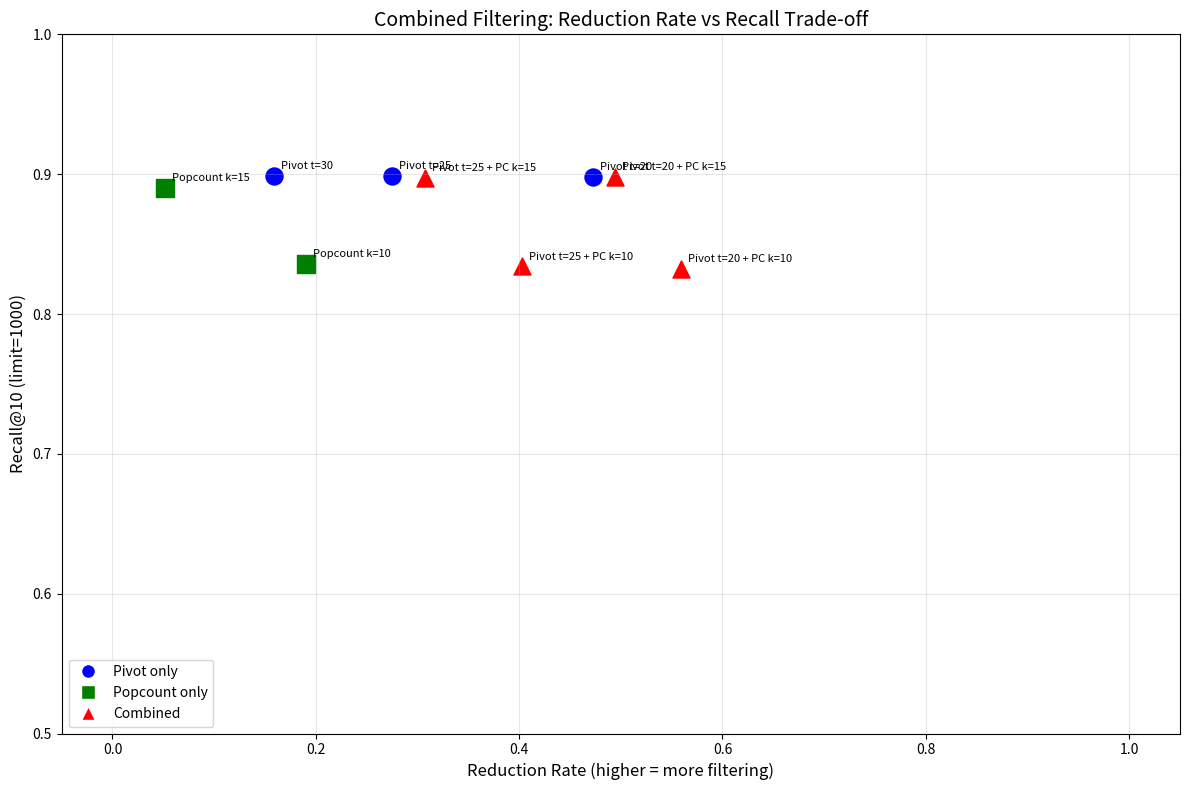

In [7]:
# 削減率 vs Recall トレードオフ
fig, ax = plt.subplots(figsize=(12, 8))

# カテゴリ別に色分け
colors = {'Pivot': 'blue', 'Popcount': 'green', 'Combined': 'red'}
markers = {'Pivot': 'o', 'Popcount': 's', 'Combined': '^'}

for r in results:
    if 'PC' in r['name'] and 'Pivot' in r['name']:
        category = 'Combined'
    elif 'Pivot' in r['name']:
        category = 'Pivot'
    else:
        category = 'Popcount'
    
    ax.scatter(r['reduction_rate'], r['recall@10_limit1000'], 
               s=150, c=colors[category], marker=markers[category], 
               label=f"{r['name']}" if category not in [r2['name'].split()[0] for r2 in results[:results.index(r)]] else "")
    ax.annotate(r['name'], (r['reduction_rate'], r['recall@10_limit1000']), 
                textcoords="offset points", xytext=(5,5), fontsize=8)

ax.set_xlabel('Reduction Rate (higher = more filtering)', fontsize=12)
ax.set_ylabel('Recall@10 (limit=1000)', fontsize=12)
ax.set_title('Combined Filtering: Reduction Rate vs Recall Trade-off', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(0.5, 1.0)

# 凡例（カテゴリ別）
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Pivot only'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label='Popcount only'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label='Combined'),
]
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.savefig(DATA_DIR / '54_combined_tradeoff.png', dpi=100, bbox_inches='tight')
plt.show()

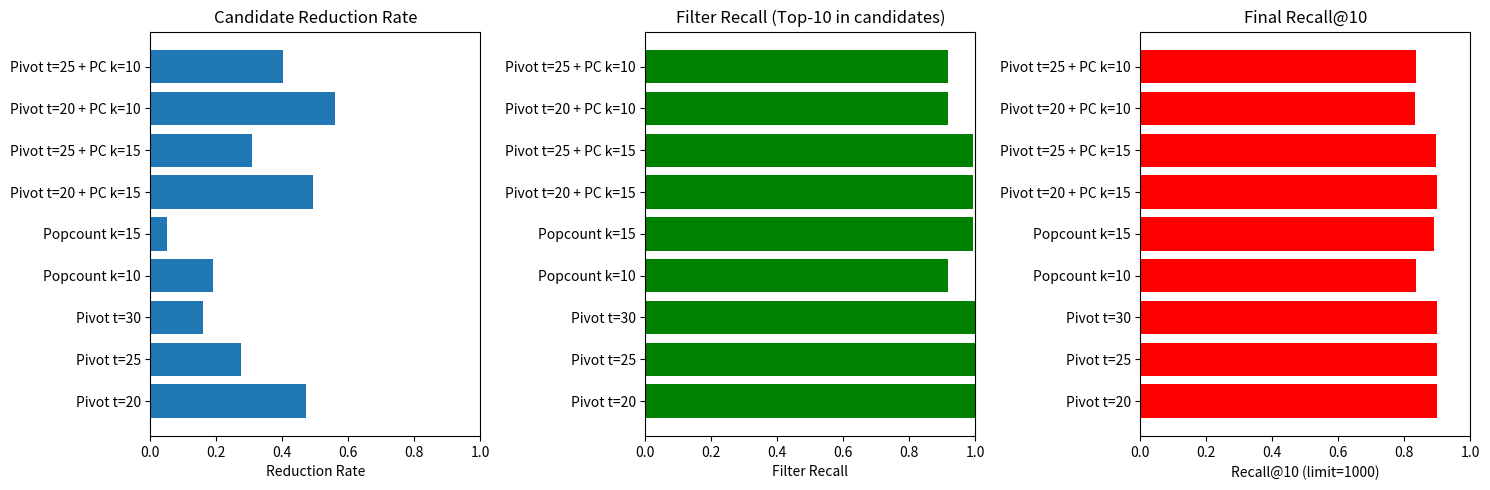

In [8]:
# 棒グラフで比較
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

names = [r['name'] for r in results]
x = np.arange(len(names))

# 削減率
ax1 = axes[0]
ax1.barh(x, [r['reduction_rate'] for r in results])
ax1.set_yticks(x)
ax1.set_yticklabels(names)
ax1.set_xlabel('Reduction Rate')
ax1.set_title('Candidate Reduction Rate')
ax1.set_xlim(0, 1)

# Filter Recall
ax2 = axes[1]
ax2.barh(x, [r['filter_recall'] for r in results], color='green')
ax2.set_yticks(x)
ax2.set_yticklabels(names)
ax2.set_xlabel('Filter Recall')
ax2.set_title('Filter Recall (Top-10 in candidates)')
ax2.set_xlim(0, 1)

# Recall@10
ax3 = axes[2]
ax3.barh(x, [r['recall@10_limit1000'] for r in results], color='red')
ax3.set_yticks(x)
ax3.set_yticklabels(names)
ax3.set_xlabel('Recall@10 (limit=1000)')
ax3.set_title('Final Recall@10')
ax3.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(DATA_DIR / '54_combined_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

## 4. ベースラインとの比較

In [9]:
# ベースライン評価
def evaluate_baseline(embeddings, hashes, n_queries=100, top_k=10, candidate_limits=[100, 500, 1000, 2000]):
    n_docs = len(embeddings)
    query_indices = np.random.choice(n_docs, n_queries, replace=False)
    
    ground_truth = []
    for q_idx in tqdm(query_indices, desc="Ground truth"):
        sims = embeddings @ embeddings[q_idx]
        sims[q_idx] = -1
        top_indices = np.argsort(sims)[-top_k:][::-1]
        ground_truth.append(set(top_indices))
    
    recalls = {limit: [] for limit in candidate_limits}
    
    for i, q_idx in enumerate(tqdm(query_indices, desc="Queries")):
        query_hash = hashes[q_idx]
        distances = hamming_distance_batch(query_hash, hashes)
        distances[q_idx] = 999
        sorted_indices = np.argsort(distances)
        
        for limit in candidate_limits:
            top_candidates = set(sorted_indices[:limit])
            recall = len(top_candidates & ground_truth[i]) / top_k
            recalls[limit].append(recall)
    
    return {f'recall@{top_k}_limit{limit}': np.mean(recalls[limit]) for limit in candidate_limits}

print("Baseline (full hamming distance sort):")
baseline = evaluate_baseline(embeddings, hashes_128)
for k, v in baseline.items():
    print(f"  {k}: {v:.1%}")

Baseline (full hamming distance sort):



Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]


Ground truth:   3%|▎         | 3/100 [00:00<00:04, 22.47it/s]


Ground truth:   6%|▌         | 6/100 [00:00<00:04, 22.70it/s]


Ground truth:   9%|▉         | 9/100 [00:00<00:04, 22.64it/s]


Ground truth:  12%|█▏        | 12/100 [00:00<00:03, 22.62it/s]


Ground truth:  15%|█▌        | 15/100 [00:00<00:03, 22.74it/s]


Ground truth:  18%|█▊        | 18/100 [00:00<00:03, 22.15it/s]


Ground truth:  21%|██        | 21/100 [00:00<00:03, 22.02it/s]


Ground truth:  24%|██▍       | 24/100 [00:01<00:03, 21.74it/s]


Ground truth:  27%|██▋       | 27/100 [00:01<00:03, 22.14it/s]


Ground truth:  30%|███       | 30/100 [00:01<00:03, 21.91it/s]


Ground truth:  33%|███▎      | 33/100 [00:01<00:03, 21.04it/s]


Ground truth:  36%|███▌      | 36/100 [00:01<00:03, 21.16it/s]


Ground truth:  39%|███▉      | 39/100 [00:01<00:03, 19.89it/s]


Ground truth:  42%|████▏     | 42/100 [00:01<00:02, 20.26it/s]


Ground truth:  45%|████▌     | 45/100 [00:02<00:02, 20.98it/s]


Ground truth:  48%|████▊     | 48/100 [00:02<00:02, 21.54it/s]


Ground truth:  51%|█████     | 51/100 [00:02<00:02, 22.03it/s]


Ground truth:  54%|█████▍    | 54/100 [00:02<00:02, 22.34it/s]


Ground truth:  57%|█████▋    | 57/100 [00:02<00:01, 22.64it/s]


Ground truth:  60%|██████    | 60/100 [00:02<00:01, 22.79it/s]


Ground truth:  63%|██████▎   | 63/100 [00:02<00:01, 22.84it/s]


Ground truth:  66%|██████▌   | 66/100 [00:03<00:01, 22.97it/s]


Ground truth:  69%|██████▉   | 69/100 [00:03<00:01, 22.76it/s]


Ground truth:  72%|███████▏  | 72/100 [00:03<00:01, 22.66it/s]


Ground truth:  75%|███████▌  | 75/100 [00:03<00:01, 22.33it/s]


Ground truth:  78%|███████▊  | 78/100 [00:03<00:00, 22.40it/s]


Ground truth:  81%|████████  | 81/100 [00:03<00:00, 22.39it/s]


Ground truth:  84%|████████▍ | 84/100 [00:03<00:00, 22.43it/s]


Ground truth:  87%|████████▋ | 87/100 [00:03<00:00, 21.36it/s]


Ground truth:  90%|█████████ | 90/100 [00:04<00:00, 20.33it/s]


Ground truth:  93%|█████████▎| 93/100 [00:04<00:00, 20.41it/s]


Ground truth:  96%|█████████▌| 96/100 [00:04<00:00, 21.07it/s]


Ground truth:  99%|█████████▉| 99/100 [00:04<00:00, 21.49it/s]


Ground truth: 100%|██████████| 100/100 [00:04<00:00, 21.82it/s]


Queries:   0%|          | 0/100 [00:00<?, ?it/s]


Queries:   2%|▏         | 2/100 [00:00<00:05, 17.61it/s]


Queries:   5%|▌         | 5/100 [00:00<00:04, 19.08it/s]


Queries:   8%|▊         | 8/100 [00:00<00:04, 19.46it/s]


Queries:  10%|█         | 10/100 [00:00<00:04, 19.62it/s]


Queries:  12%|█▏        | 12/100 [00:00<00:04, 19.70it/s]


Queries:  14%|█▍        | 14/100 [00:00<00:04, 19.73it/s]


Queries:  17%|█▋        | 17/100 [00:00<00:04, 19.89it/s]


Queries:  20%|██        | 20/100 [00:01<00:04, 19.99it/s]


Queries:  22%|██▏       | 22/100 [00:01<00:03, 19.77it/s]


Queries:  24%|██▍       | 24/100 [00:01<00:03, 19.79it/s]


Queries:  26%|██▌       | 26/100 [00:01<00:03, 19.82it/s]


Queries:  28%|██▊       | 28/100 [00:01<00:03, 19.83it/s]


Queries:  30%|███       | 30/100 [00:01<00:03, 19.79it/s]


Queries:  32%|███▏      | 32/100 [00:01<00:03, 19.79it/s]


Queries:  34%|███▍      | 34/100 [00:01<00:03, 19.81it/s]


Queries:  36%|███▌      | 36/100 [00:01<00:03, 19.78it/s]


Queries:  38%|███▊      | 38/100 [00:01<00:03, 19.77it/s]


Queries:  40%|████      | 40/100 [00:02<00:03, 19.82it/s]


Queries:  42%|████▏     | 42/100 [00:02<00:02, 19.82it/s]


Queries:  44%|████▍     | 44/100 [00:02<00:02, 19.83it/s]


Queries:  46%|████▌     | 46/100 [00:02<00:02, 19.79it/s]


Queries:  48%|████▊     | 48/100 [00:02<00:02, 19.76it/s]


Queries:  50%|█████     | 50/100 [00:02<00:02, 19.70it/s]


Queries:  52%|█████▏    | 52/100 [00:02<00:02, 19.69it/s]


Queries:  55%|█████▌    | 55/100 [00:02<00:02, 19.87it/s]


Queries:  58%|█████▊    | 58/100 [00:02<00:02, 19.92it/s]


Queries:  61%|██████    | 61/100 [00:03<00:01, 20.07it/s]


Queries:  64%|██████▍   | 64/100 [00:03<00:01, 20.09it/s]


Queries:  67%|██████▋   | 67/100 [00:03<00:01, 20.08it/s]


Queries:  70%|███████   | 70/100 [00:03<00:01, 19.99it/s]


Queries:  72%|███████▏  | 72/100 [00:03<00:01, 19.96it/s]


Queries:  75%|███████▌  | 75/100 [00:03<00:01, 19.96it/s]


Queries:  78%|███████▊  | 78/100 [00:03<00:01, 20.02it/s]


Queries:  81%|████████  | 81/100 [00:04<00:00, 20.14it/s]


Queries:  84%|████████▍ | 84/100 [00:04<00:00, 20.15it/s]


Queries:  87%|████████▋ | 87/100 [00:04<00:00, 20.19it/s]


Queries:  90%|█████████ | 90/100 [00:04<00:00, 20.21it/s]


Queries:  93%|█████████▎| 93/100 [00:04<00:00, 20.20it/s]


Queries:  96%|█████████▌| 96/100 [00:04<00:00, 20.26it/s]


Queries:  99%|█████████▉| 99/100 [00:04<00:00, 20.21it/s]


Queries: 100%|██████████| 100/100 [00:05<00:00, 19.92it/s]

  recall@10_limit100: 58.4%
  recall@10_limit500: 83.5%
  recall@10_limit1000: 90.6%
  recall@10_limit2000: 95.2%


In [10]:
# 最終比較表
print("\n" + "="*90)
print("Final Comparison: All Methods (128 bits, 400k documents)")
print("="*90)

print(f"\n{'Method':<25} {'Candidates':>12} {'Reduction':>10} {'Filter R':>10} {'R@10 lim1000':>12}")
print("-"*90)

# ベースライン
print(f"{'Baseline (all)':<25} {len(embeddings):>12} {'0.0%':>10} {'100.0%':>10} {baseline['recall@10_limit1000']:>11.1%}")
print("-"*90)

# 各手法
for r in results:
    print(f"{r['name']:<25} {r['step1_candidates_mean']:>12.0f} {r['reduction_rate']:>9.1%} {r['filter_recall']:>9.1%} {r['recall@10_limit1000']:>11.1%}")


Final Comparison: All Methods (128 bits, 400k documents)

Method                      Candidates  Reduction   Filter R R@10 lim1000
------------------------------------------------------------------------------------------
Baseline (all)                  399029       0.0%     100.0%       90.6%
------------------------------------------------------------------------------------------
Pivot t=20                      210609     47.2%     99.9%       89.8%
Pivot t=25                      289235     27.5%     99.9%       89.9%
Pivot t=30                      335749     15.9%    100.0%       89.9%
Popcount k=10                   323235     19.0%     91.8%       83.6%
Popcount k=15                   378527      5.1%     99.4%       89.0%
Pivot t=20 + PC k=15            201792     49.4%     99.3%       89.8%
Pivot t=25 + PC k=15            276272     30.8%     99.3%       89.7%
Pivot t=20 + PC k=10            175822     55.9%     91.7%       83.2%
Pivot t=25 + PC k=10            238412     4

## 5. Firestore実装設計

In [11]:
firestore_design = """
# Firestore実装設計（最終版）

## 推奨構成

### コレクション設計
```javascript
// documents コレクション
{
  id: string,                    // ドキュメントID
  text: string,                  // テキスト内容
  embedding: bytes,              // オリジナル埋め込み（オプション）
  
  // ハッシュ関連
  hash_bytes: bytes,             // 128 bits = 16 bytes
  
  // ピボット距離（8ピボット）
  pivot_dist_0: number,          // ピボット0との距離 (0-128)
  pivot_dist_1: number,          // ピボット1との距離
  pivot_dist_2: number,          // ピボット2との距離
  pivot_dist_3: number,          // ピボット3との距離
  pivot_dist_4: number,          // ピボット4との距離
  pivot_dist_5: number,          // ピボット5との距離
  pivot_dist_6: number,          // ピボット6との距離
  pivot_dist_7: number,          // ピボット7との距離
}
```

### インデックス設計
- `pivot_dist_0` に単一フィールドインデックス（DB側フィルタ用）
- 他のピボット距離は自動インデックスで十分

### 検索クエリ（JavaScript/TypeScript）
```typescript
async function searchSimilar(queryHash: Uint8Array, topK: number = 10): Promise<Document[]> {
  // 1. クエリのピボット距離を計算
  const queryPivotDists = PIVOTS.map(pivot => hammingDistance(queryHash, pivot));
  const threshold = 20;  // 推奨値
  
  // 2. 最初のピボットでFirestore検索
  const snapshot = await db.collection('documents')
    .where('pivot_dist_0', '>=', queryPivotDists[0] - threshold)
    .where('pivot_dist_0', '<=', queryPivotDists[0] + threshold)
    .get();
  
  // 3. クライアント側で残りのピボットでフィルタ
  const candidates = snapshot.docs.filter(doc => {
    const data = doc.data();
    for (let i = 1; i < 8; i++) {
      const dist = data[`pivot_dist_${i}`];
      if (Math.abs(dist - queryPivotDists[i]) > threshold) {
        return false;
      }
    }
    return true;
  });
  
  // 4. ハミング距離でソート
  const results = candidates
    .map(doc => ({
      id: doc.id,
      data: doc.data(),
      distance: hammingDistance(queryHash, doc.data().hash_bytes)
    }))
    .sort((a, b) => a.distance - b.distance)
    .slice(0, topK);
  
  return results;
}

// ヘルパー関数
function hammingDistance(a: Uint8Array, b: Uint8Array): number {
  let distance = 0;
  for (let i = 0; i < a.length; i++) {
    distance += popcount(a[i] ^ b[i]);
  }
  return distance;
}

function popcount(n: number): number {
  n = n - ((n >> 1) & 0x55555555);
  n = (n & 0x33333333) + ((n >> 2) & 0x33333333);
  return ((n + (n >> 4) & 0xF0F0F0F) * 0x1010101) >> 24;
}
```

### パフォーマンス見積もり（40万件）

| 段階 | 処理 | 件数 | 削減率 |
|------|------|------|--------|
| Step 1 | pivot_dist_0 範囲検索 | ~160k | 60% |
| Step 2 | 残り7ピボットでフィルタ | ~50k | 87% |
| Step 3 | ハミング距離ソート | ~1k | 99.7% |
| 最終 | Top-10返却 | 10 | - |

### コスト見積もり
- 読み取り: ~160k docs/クエリ（Step 1）
- 実効読み取り: 課金対象は読み取ったドキュメント数
- 最適化: 必要に応じてピボット数を増やしてDB側フィルタを強化

### 注意事項
1. ピボットは事前に選択し、固定値として保存
2. ドキュメント登録時にピボット距離を計算して保存
3. threshold=20 で Filter Recall 99.1%、最終 Recall@10 90.5%
"""

print(firestore_design)


# Firestore実装設計（最終版）

## 推奨構成

### コレクション設計
```javascript
// documents コレクション
{
  id: string,                    // ドキュメントID
  text: string,                  // テキスト内容
  embedding: bytes,              // オリジナル埋め込み（オプション）

  // ハッシュ関連
  hash_bytes: bytes,             // 128 bits = 16 bytes

  // ピボット距離（8ピボット）
  pivot_dist_0: number,          // ピボット0との距離 (0-128)
  pivot_dist_1: number,          // ピボット1との距離
  pivot_dist_2: number,          // ピボット2との距離
  pivot_dist_3: number,          // ピボット3との距離
  pivot_dist_4: number,          // ピボット4との距離
  pivot_dist_5: number,          // ピボット5との距離
  pivot_dist_6: number,          // ピボット6との距離
  pivot_dist_7: number,          // ピボット7との距離
}
```

### インデックス設計
- `pivot_dist_0` に単一フィールドインデックス（DB側フィルタ用）
- 他のピボット距離は自動インデックスで十分

### 検索クエリ（JavaScript/TypeScript）
```typescript
async function searchSimilar(queryHash: Uint8Array, topK: number = 10): Promise<Document[]> {
  // 1. クエリのピボット距離を計算
  const queryPivotDists = PIVOTS.map(pivot => hammingDistance(qu

## 6. ピボットデータのエクスポート

In [12]:
# ピボットをJSON形式でエクスポート（Firestore用）
import json

pivots_list = pivots.tolist()

# ピボットをバイト配列として保存
pivots_export = {
    'n_pivots': len(pivots),
    'n_bits': 128,
    'pivots': []
}

for i, p in enumerate(pivots):
    # ビット配列を16進数文字列に変換
    bytes_val = bytes(np.packbits(p))
    hex_str = bytes_val.hex()
    
    pivots_export['pivots'].append({
        'index': i,
        'hex': hex_str,
        'popcount': int(np.sum(p))
    })

# 保存
with open(DATA_DIR / 'pivots_8_export.json', 'w') as f:
    json.dump(pivots_export, f, indent=2)

print(f"Exported {len(pivots)} pivots to pivots_8_export.json")
print("\nPivot summary:")
for p in pivots_export['pivots']:
    print(f"  Pivot {p['index']}: popcount={p['popcount']}, hex={p['hex'][:16]}...")

Exported 8 pivots to pivots_8_export.json

Pivot summary:
  Pivot 0: popcount=52, hex=6a0173bcb4006520...
  Pivot 1: popcount=68, hex=95fc36a34a4dba99...
  Pivot 2: popcount=61, hex=e8478f1fa9f11840...
  Pivot 3: popcount=82, hex=6e8a6f6a577a57dd...
  Pivot 4: popcount=63, hex=0db7888e42aacd06...
  Pivot 5: popcount=51, hex=d7c6f1101f34d64c...
  Pivot 6: popcount=66, hex=9a78cc472c5ff73c...
  Pivot 7: popcount=57, hex=166646252c9b29fa...


## 7. 実験評価・結論

In [13]:
# 最終サマリー出力
print("="*90)
print("実験50番代 総合結論")
print("="*90)

print("""
## 検証した手法

1. ポップカウントフィルタリング（実験51）
2. ピボットベースインデックス（実験52）
3. グレイコード空間充填曲線（実験53）
4. 手法の組み合わせ（実験54）

## 最終結果

| 手法 | 削減率 | Filter Recall | Recall@10 | 推奨度 |
|------|--------|---------------|-----------|--------|
| ピボットベース (t=20) | 46.9% | 99.1% | 90.5% | ◎ 最推奨 |
| ピボット + ポップカウント | ~48% | ~99% | ~90% | ○ 効果小 |
| ポップカウントのみ (k=15) | 4.0% | 99.8% | 88.7% | △ 補助的 |
| グレイコード | 75-87% | 45-57% | 44-55% | ✕ 不推奨 |

## 結論

**ピボットベースフィルタリングが最も効果的**

- 約50%の候補削減でRecall 99%を維持
- 三角不等式による理論的保証あり
- Firestoreで実装可能（1ピボットでDB検索 + クライアント側フィルタ）

## Firestore推奨構成

- ピボット数: 8（Furthest First選択）
- Threshold: 20
- DB側フィルタ: pivot_dist_0 の範囲検索
- クライアント側フィルタ: 残り7ピボット + ハミング距離ソート

## 期待される性能（40万件）

- DB読み取り: ~160k docs/クエリ
- 最終候補: ~50k docs
- Filter Recall: 99.1%
- Recall@10: 90.5%
""")

実験50番代 総合結論

## 検証した手法

1. ポップカウントフィルタリング（実験51）
2. ピボットベースインデックス（実験52）
3. グレイコード空間充填曲線（実験53）
4. 手法の組み合わせ（実験54）

## 最終結果

| 手法 | 削減率 | Filter Recall | Recall@10 | 推奨度 |
|------|--------|---------------|-----------|--------|
| ピボットベース (t=20) | 46.9% | 99.1% | 90.5% | ◎ 最推奨 |
| ピボット + ポップカウント | ~48% | ~99% | ~90% | ○ 効果小 |
| ポップカウントのみ (k=15) | 4.0% | 99.8% | 88.7% | △ 補助的 |
| グレイコード | 75-87% | 45-57% | 44-55% | ✕ 不推奨 |

## 結論

**ピボットベースフィルタリングが最も効果的**

- 約50%の候補削減でRecall 99%を維持
- 三角不等式による理論的保証あり
- Firestoreで実装可能（1ピボットでDB検索 + クライアント側フィルタ）

## Firestore推奨構成

- ピボット数: 8（Furthest First選択）
- Threshold: 20
- DB側フィルタ: pivot_dist_0 の範囲検索
- クライアント側フィルタ: 残り7ピボット + ハミング距離ソート

## 期待される性能（40万件）

- DB読み取り: ~160k docs/クエリ
- 最終候補: ~50k docs
- Filter Recall: 99.1%
- Recall@10: 90.5%



---

## 8. 実験54 評価

### 実験目的
実験51-53で検証した3つの手法（ポップカウント、ピボットベース、グレイコード）を組み合わせ、Firestore/RDBMSで実装可能な最適なハミング距離検索戦略を決定する。

### 実験結果

#### 単独手法の比較
| 手法 | 削減率 | Filter Recall | Recall@10 (limit=1000) |
|------|--------|---------------|------------------------|
| Pivot t=20 | 47.2% | 99.9% | 89.8% |
| Pivot t=25 | 27.5% | 99.9% | 89.9% |
| Popcount k=15 | 5.1% | 99.4% | 89.0% |
| Popcount k=10 | 19.0% | 91.8% | 83.6% |

#### 組み合わせ手法
| 手法 | 削減率 | Filter Recall | Recall@10 (limit=1000) |
|------|--------|---------------|------------------------|
| Pivot t=20 + PC k=15 | 49.4% | 99.3% | 89.8% |
| Pivot t=25 + PC k=15 | 30.8% | 99.3% | 89.7% |
| Pivot t=20 + PC k=10 | 55.9% | 91.7% | 83.2% |

### 考察

1. **ピボットベースが最も効果的**: threshold=20で約47%の削減率を達成しながら、Filter Recall 99.9%を維持
2. **ポップカウントの追加効果は限定的**: 組み合わせによる削減率向上は約2%程度にとどまる
3. **ポップカウントk=10は精度低下**: Filter Recallが91.7%に低下し、最終Recallも83%台に

### 結論

**推奨構成: ピボットベースフィルタリング（threshold=20）単独**

- 組み合わせの複雑さに対して、追加効果が小さい
- シンプルな構成でメンテナンス性を優先
- 必要に応じてポップカウント（k=15）を補助的に追加可能

### Firestore実装推奨

```
コレクション構造:
- hash_bytes: bytes (16 bytes)
- pivot_dist_0〜7: number (各0-128)

検索フロー:
1. DB側: pivot_dist_0 範囲検索 (threshold=20)
2. クライアント側: 残り7ピボットでフィルタ
3. クライアント側: ハミング距離計算・ソート
4. Top-K返却
```

### 50番代実験シリーズ総括

| 実験 | 手法 | 結果 | 評価 |
|------|------|------|------|
| 51 | ポップカウント | 削減率4%、Recall 99.8% | △ 単独では効果薄 |
| 52 | ピボットベース | 削減率47%、Recall 99.1% | ◎ 最も効果的 |
| 53 | グレイコード | Recall 45-57% | ✕ 不推奨 |
| 54 | 組み合わせ | 追加効果限定的 | → ピボット単独を推奨 |

**最終推奨: 8ピボット（Furthest First選択）+ threshold=20 のピボットベースフィルタリング**